In [1]:
%load_ext autoreload
%autoreload 2

# ARGOVision × POLIMI: anomaly detection in the industry

In this workshop we will investigate the usage of a well-kown anomaly detection technique known in literature with the name of PatchCore.

In [8]:
import sys

In [9]:
sys.path.append("/work/patchcore-inspection")
sys.path.append("/work/patchcore-inspection/src")

In [10]:
from utils import ALL_CATEGORIES, commandline_args, get_train_args, get_evaluate_args

In [11]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import numpy as np
from PIL import Image
from typing import Sequence, Tuple
from tqdm import tqdm

In [12]:
def load_pickle(fpath: Path) -> Dict:
    with open(str(fpath), "rb") as handle:
        data = pickle.load(handle)

    return data

In [13]:
ROOT = Path("/work")
METRIC_NAMES = ["instance_auroc","full_pixel_auroc","anomaly_pixel_auroc"]
EXPERIMENTS_FOLDER = "experiments"

# Step 1

Execute a training (also called fitting) using the PatchCore algorithm. Choose arbitrarily the categories and the image size.

In [14]:
exp_name="0001"
image_size = 224
num_categories = 1
categories = ALL_CATEGORIES[:num_categories]

In [15]:
from bin.run_patchcore import main as trainer

with commandline_args(*get_train_args(exp_name, dst_folders=(EXPERIMENTS_FOLDER, "step1"), image_size=image_size, categories=categories)):
    try:
        trainer()
    except SystemExit:
        print("Done")

/root/.local/share/virtualenvs/work-WgJkZa2_/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/root/.local/share/virtualenvs/work-WgJkZa2_/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.local/share/virtualenvs/work-WgJkZa2_/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the futur

Done


# Step 2

Execute an evaluation (using the evaluation script) using the PatchCore algorithm. Use the models obtained at the end of the previous step.

In [16]:
_experiment_folder = ROOT / EXPERIMENTS_FOLDER /"step1" / exp_name
results_dst_folder = _experiment_folder / "evaluated"
model_paths = [str(_experiment_folder / "models" / f"mvtec_{category_name}") for category_name in categories]

In [17]:
from bin.load_and_evaluate_patchcore import main as evaluator

with commandline_args(*get_evaluate_args(
    results_dst_folder=str(results_dst_folder), 
    model_paths=model_paths, 
    categories=categories, 
    image_size=image_size
    )
):
        try:
            evaluator()
        except SystemExit:
            print("Done.")

/root/.local/share/virtualenvs/work-WgJkZa2_/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/root/.local/share/virtualenvs/work-WgJkZa2_/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/.local/share/virtualenvs/work-WgJkZa2_/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the futur

Done.


# Step 3

Generate a score distribution over all the available classes:

- Use the results (results.csv) obtained from the model `step1/0000` in the experiments folder.
- All the models have been trained using an image size equal to 224x224.

In [18]:
PATH_TO_PRETRAINED_MODELS = ROOT / EXPERIMENTS_FOLDER / "step1" / "0000"

In [19]:
results_fpath = PATH_TO_PRETRAINED_MODELS / "results.csv"

df = pd.read_csv(results_fpath, usecols=["Row Names", *METRIC_NAMES])

In [20]:
df

Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0       mvtec_bottle        1.000000          0.981734             0.976010
1        mvtec_cable        0.971889          0.953732             0.945150
2      mvtec_capsule        0.963303          0.972025             0.969934
3       mvtec_carpet        0.985955          0.989872             0.987238
4         mvtec_grid        0.979114          0.964977             0.961541
5     mvtec_hazelnut        0.999643          0.982444             0.973581
6      mvtec_leather        1.000000          0.992893             0.990400
7    mvtec_metal_nut        0.967253          0.956465             0.952074
8         mvtec_pill        0.936716          0.948044             0.946133
9        mvtec_screw        0.747489          0.941260             0.939366
10        mvtec_tile        0.989899          0.955791             0.938607
11  mvtec_toothbrush        0.894444          0.970330             0.964594
12  mvtec_transistor        0.985417          0.879276             0.850983
13        mvtec_wood        0.991228          0.947303             0.933791
14      mvtec_zipper        0.987920          0.981371             0.977595
15              Mean       -1.000000         -1.000000            -1.000000

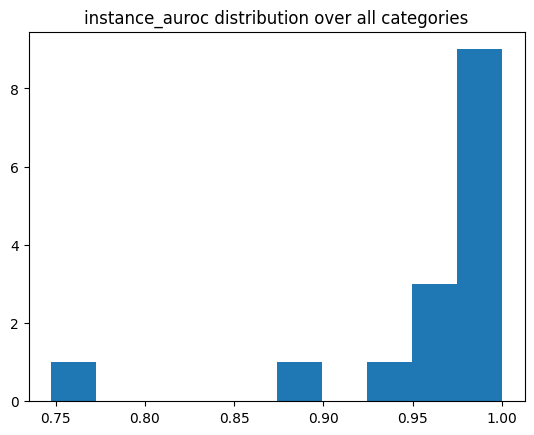

In [21]:
metric_selected = "instance_auroc"
df[:-1][metric_selected].hist(grid=False)

plt.title(f"{metric_selected} distribution over all categories")
plt.show()

# Step 4

Generate the anomaly masks on test images related to one of the available categories:

- Change the script code so that the predictions, the ground-truth (pixelwise and imagewise), image names and anomaly threshold, all were saved in a file to make them available after the evaluation
- Execute an evaluation using a pre-trained model, generating the file with the saved data for one category
- Plot the histograms related to the pixelwise and imagewise scorse, comparing the score of images containing anomalies with those of images without anomalies
- In the pixelwise case, add to the plot the optimal threshold selected by the algorithm

In [22]:
results_dst_folder = PATH_TO_PRETRAINED_MODELS / "evaluated"
model_paths = [str(PATH_TO_PRETRAINED_MODELS / "models" / f"mvtec_{category_name}") for category_name in ALL_CATEGORIES]

In [ ]:
from bin.load_and_evaluate_patchcore import main as evaluator
args = get_evaluate_args(
    results_dst_folder=str(results_dst_folder), 
    model_paths=model_paths, 
    categories=ALL_CATEGORIES, 
    image_size=image_size
    )
with commandline_args(*args):
        try:
            evaluator()
        except SystemExit:
            print("Done.")

In [23]:
def plot_imagewise_score_distribution(fpath2data: Path):
    data = load_pickle(fpath2data)

    gts = data["imagewise_gt"].astype(bool)
    preds = data["imagewise_pred"]

    defective = preds[gts]
    flawless = preds[~gts]

    print(f"defective preds.shape: {flawless.shape}")
    print(f"flawless preds.shape: {defective.shape}")

    plt.hist(defective, bins=20, alpha=0.8)
    plt.hist(flawless, alpha=0.6)
    plt.title("Imagewise anomaly score distribution")
    plt.show()

defective preds.shape: (20,)
flawless preds.shape: (63,)


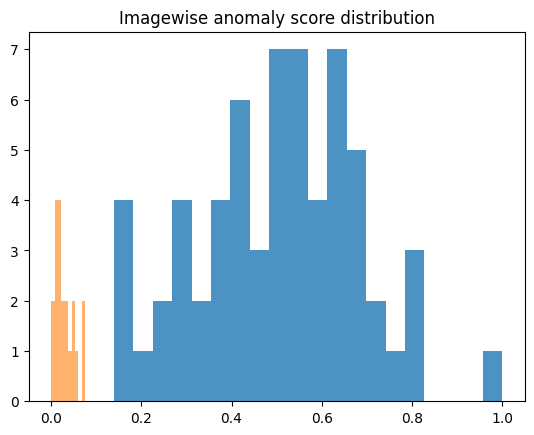

In [24]:
select_category = "bottle"
plot_imagewise_score_distribution(results_dst_folder / f"mvtec_{select_category}.pkl")

In [25]:
def plot_pixelwise_score_distribution(fpath2data: Path):
    data = load_pickle(fpath2data)

    gts = data["pixelwise_gt"][:, 0, ...].astype(bool)
    preds = data["pixelwise_pred"]
    threshold = data["optimal_threshold"]

    defective = preds[gts]
    flawless = preds[~gts]

    print(f"defective pixels.shape: {defective.shape}")
    print(f"flawless pixels.shape: {flawless.shape}")
    
    plt.hist(defective, bins=20, alpha=0.8)
    plt.hist(flawless, bins=20, alpha=0.6)
    plt.plot([threshold, threshold], [0, 1_500_000])
    plt.title("Pixelwise anomaly score distribution")
    plt.show()

defective pixels.shape: (335668,)
flawless pixels.shape: (3828940,)


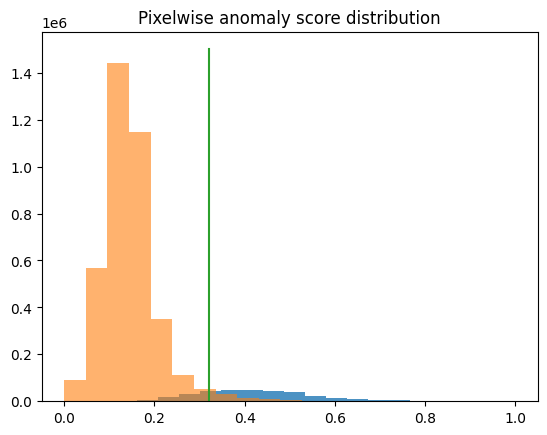

In [26]:
selected_category = "bottle"
plot_pixelwise_score_distribution(results_dst_folder / f"mvtec_{selected_category}.pkl")

## Steps 5-6

Identify the category with worst performances using the results generated by the pre-trained model in the previous steps:

- Sort the examples in the worst cathegory with respect to one of the available metrics
- Identify N worst examples (a small number, just to see them, say 3)
- Plot the found examples showing: the original image, the anomaly mask, the binarized anomaly mask, the ground-truth mask

Repeat the previous step selecting the the best category and the best examples.

In [33]:
def get_examples_from_category(
    fpath2data: Path, 
    num_examples: int, 
    best_category: bool = False, 
    best_examples: bool = False, 
    only_defective: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    df = pd.read_csv(fpath2data / "results.csv", usecols=["Row Names", *METRIC_NAMES])

    print(df)

    def select_category() -> str:
        getter = lambda x: x.idxmin()
        if best_category:
             getter = lambda x: x.idxmax() 
        
        selected_metric = "full_pixel_auroc"
        idx = getter(df[selected_metric][:-1])
        
        return df.iloc[idx]["Row Names"]


    def sort_examples_by_metric_score(gts: np.ndarray, preds: np.ndarray, category_name: str, num_examples: int) -> Tuple[np.ndarray, np.ndarray]:
        _scores = []
        for gt, pred in tqdm(zip(gts, preds), desc="Computing scores..."):
            score = f1_score(y_true=gt.ravel(), y_pred=(pred.ravel() > threshold).astype(int))
            _scores.append(score)

        scores = np.array(_scores)
            
        return np.argpartition(-scores if best_examples else scores, num_examples), scores

    def identify_n_examples(sorted_idxs_scores: np.ndarray, num_examples: int) -> np.ndarray:
        return sorted_idxs_scores[:num_examples]

    category_name = select_category()
    print(f"The selected category is: {category_name}")

    data = load_pickle(results_dst_folder / f"{category_name}.pkl")
    gts = data["pixelwise_gt"][:, 0, ...].astype(int)
    preds = data["pixelwise_pred"]
    image_fnames = data["fnames"]
    threshold = data["optimal_threshold"]

    if only_defective:
        gts_iw = data["imagewise_gt"].astype(bool)
        gts = gts[gts_iw]
        preds = preds[gts_iw]
        image_fnames = image_fnames[gts_iw]

    print(f"Number of examples: {len(gts)}")

    sorted_idxs_scores, scores = sort_examples_by_metric_score(gts, preds, category_name=category_name, num_examples=num_examples)
    selected_idxs = identify_n_examples(sorted_idxs_scores, num_examples)
    
    fnames = image_fnames[selected_idxs]
    preds = preds[selected_idxs]
    gts = gts[selected_idxs]
    scores = scores[selected_idxs]

    return fnames, preds, gts, threshold, scores

In [34]:
def plot_examples(fnames: Sequence[str], preds: np.ndarray, gts: np.ndarray, scores: np.ndarray, threshold: float) -> None:
    print(f"Threshold: {threshold:.4f}")
    for fname, pred, gt, score in zip(fnames, preds, gts, scores):
        plot_example(fname, pred, gt, score, threshold)   

def plot_example(fname: str, pred: np.ndarray, gt: np.ndarray, score: float, threshold: float) -> None:
    image = Image.open(fname)
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"Metric score: {score:.4f}\nDefect type: {Path(fname).parent.name}")
    
    axes[0].imshow(image)
    axes[0].set_title(fname.split("/")[-1])

    axes[1].imshow(pred)
    axes[1].set_title(f"anomaly mask (max: {pred.max():.4f})")

    axes[2].imshow(pred > threshold)
    axes[2].set_title("pred (thresholded)")

    axes[3].imshow(gt)
    axes[3].set_title("gt")
    plt.axis('off')
    plt.show()

Best category - best examples

           Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0       mvtec_bottle        1.000000          0.981734             0.976010
1        mvtec_cable        0.971889          0.953732             0.945150
2      mvtec_capsule        0.963303          0.972025             0.969934
3       mvtec_carpet        0.985955          0.989872             0.987238
4         mvtec_grid        0.979114          0.964977             0.961541
5     mvtec_hazelnut        0.999643          0.982444             0.973581
6      mvtec_leather        1.000000          0.992893             0.990400
7    mvtec_metal_nut        0.967253          0.956465             0.952074
8         mvtec_pill        0.936716          0.948044             0.946133
9        mvtec_screw        0.747489          0.941260             0.939366
10        mvtec_tile        0.989899          0.955791             0.938607
11  mvtec_toothbrush        0.894444          0.970330             0.964594
12  mvtec_tr

Computing scores...: 92it [00:01, 58.87it/s]


Threshold: 0.3582


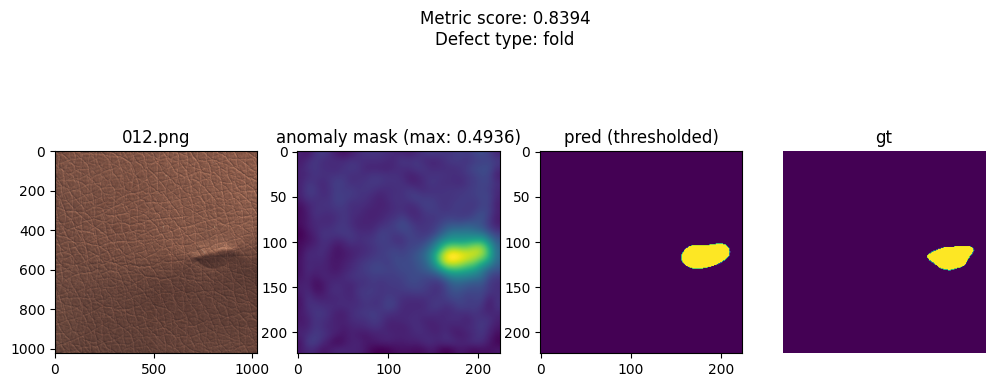

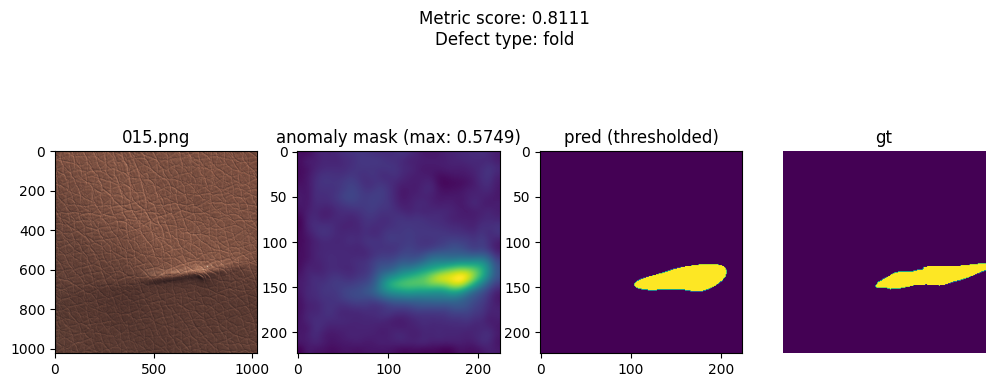

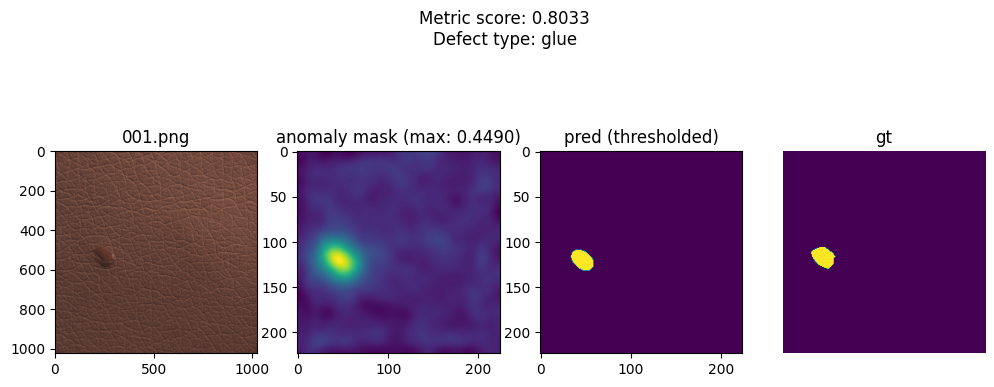

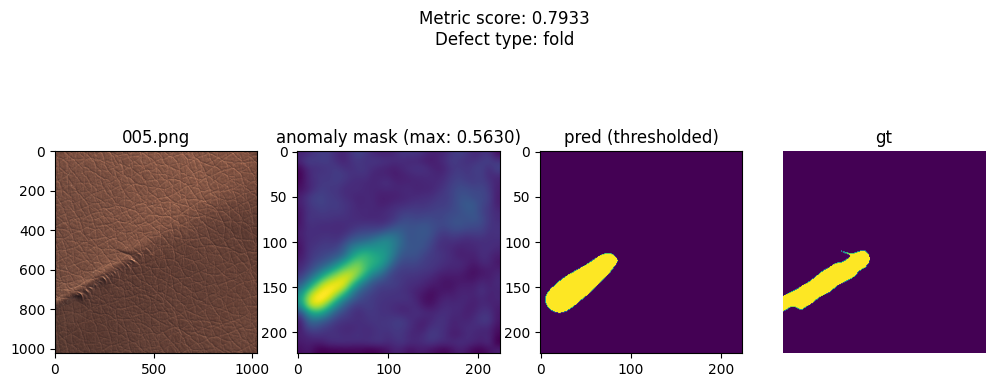

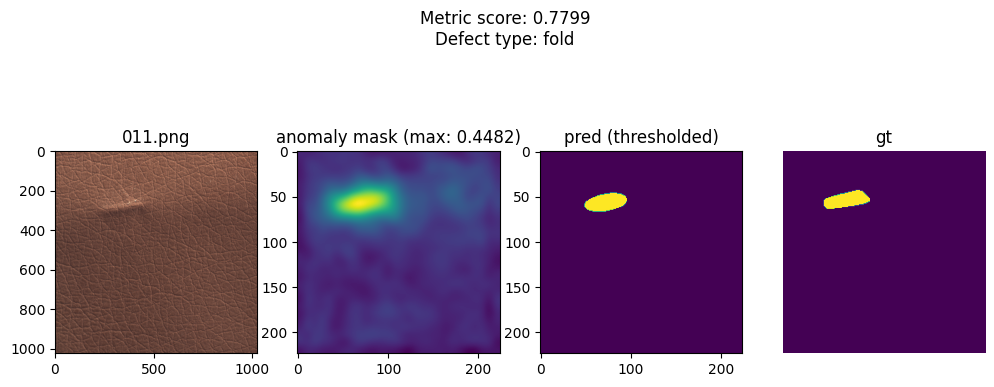

In [36]:
fnames, preds, gts, threshold, scores = get_examples_from_category(
    fpath2data=results_dst_folder, 
    num_examples=5, 
    best_category=True, 
    best_examples=True
)
plot_examples(fnames, preds, gts, scores, threshold)

Best category - worst examples

           Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0       mvtec_bottle        1.000000          0.981734             0.976010
1        mvtec_cable        0.971889          0.953732             0.945150
2      mvtec_capsule        0.963303          0.972025             0.969934
3       mvtec_carpet        0.985955          0.989872             0.987238
4         mvtec_grid        0.979114          0.964977             0.961541
5     mvtec_hazelnut        0.999643          0.982444             0.973581
6      mvtec_leather        1.000000          0.992893             0.990400
7    mvtec_metal_nut        0.967253          0.956465             0.952074
8         mvtec_pill        0.936716          0.948044             0.946133
9        mvtec_screw        0.747489          0.941260             0.939366
10        mvtec_tile        0.989899          0.955791             0.938607
11  mvtec_toothbrush        0.894444          0.970330             0.964594
12  mvtec_tr

Computing scores...: 92it [00:01, 65.15it/s]


Threshold: 0.3582


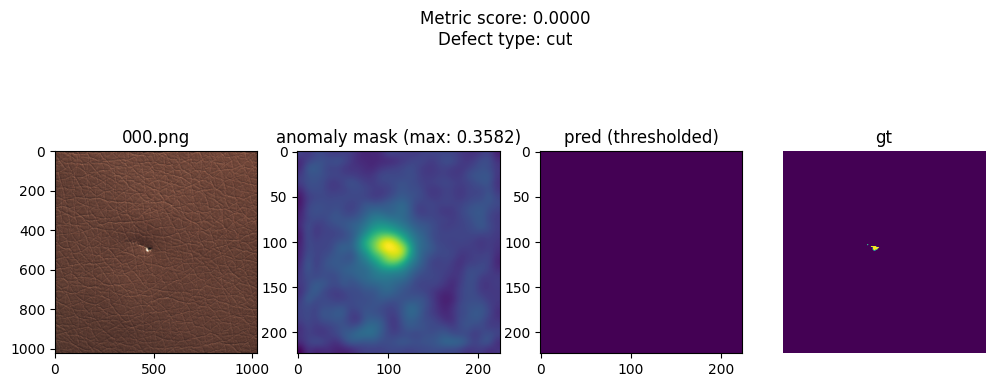

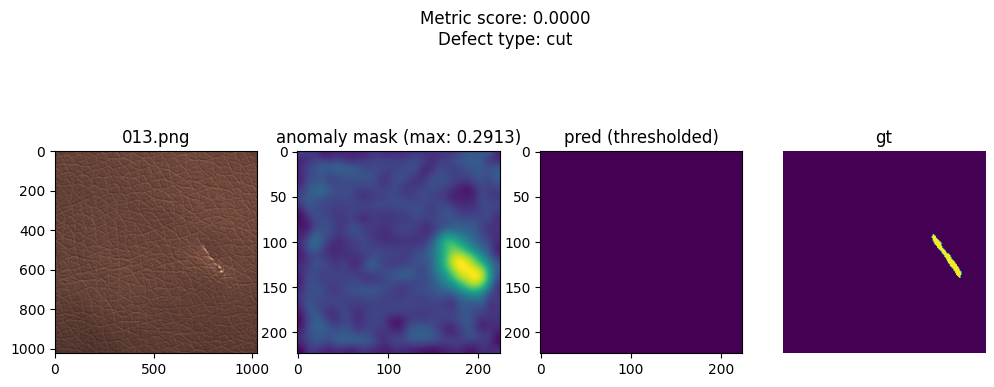

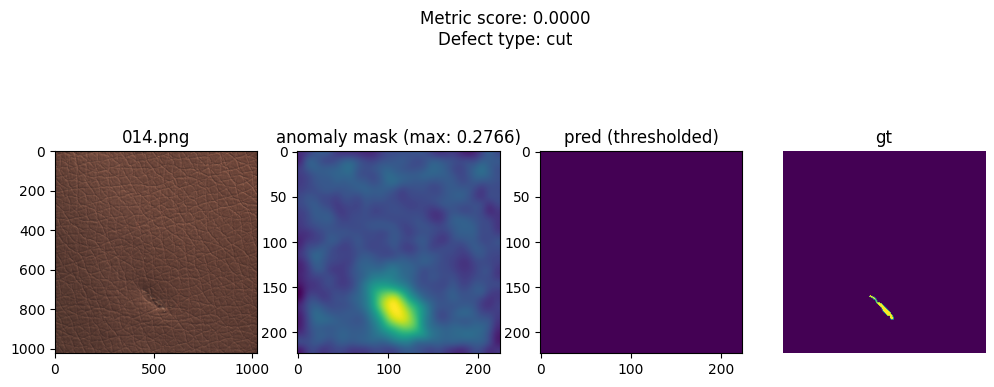

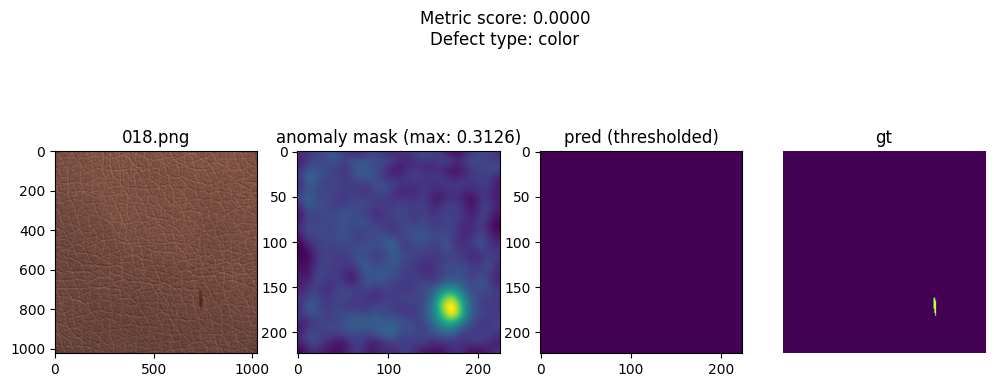

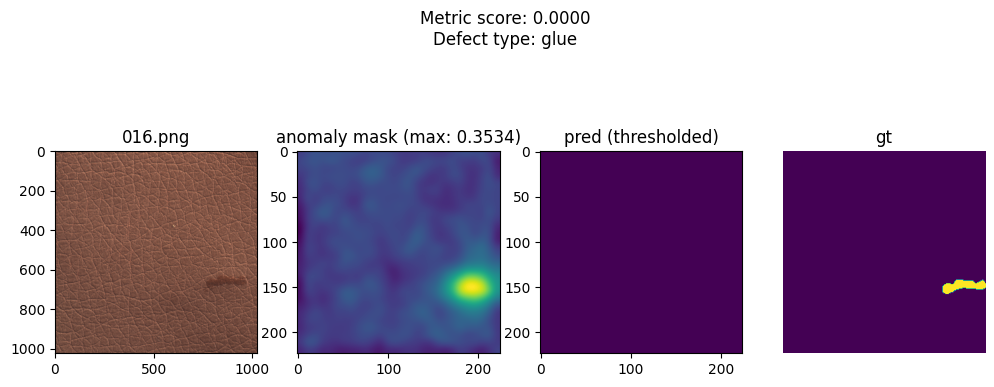

In [37]:
fnames, preds, gts, threshold, scores = get_examples_from_category(
    fpath2data=results_dst_folder, 
    num_examples=5, 
    best_category=True, 
    best_examples=False
)
plot_examples(fnames, preds, gts, scores, threshold)

Worst category - best examples

           Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0       mvtec_bottle        1.000000          0.981734             0.976010
1        mvtec_cable        0.971889          0.953732             0.945150
2      mvtec_capsule        0.963303          0.972025             0.969934
3       mvtec_carpet        0.985955          0.989872             0.987238
4         mvtec_grid        0.979114          0.964977             0.961541
5     mvtec_hazelnut        0.999643          0.982444             0.973581
6      mvtec_leather        1.000000          0.992893             0.990400
7    mvtec_metal_nut        0.967253          0.956465             0.952074
8         mvtec_pill        0.936716          0.948044             0.946133
9        mvtec_screw        0.747489          0.941260             0.939366
10        mvtec_tile        0.989899          0.955791             0.938607
11  mvtec_toothbrush        0.894444          0.970330             0.964594
12  mvtec_tr

Computing scores...: 40it [00:00, 65.77it/s]


Threshold: 0.3603


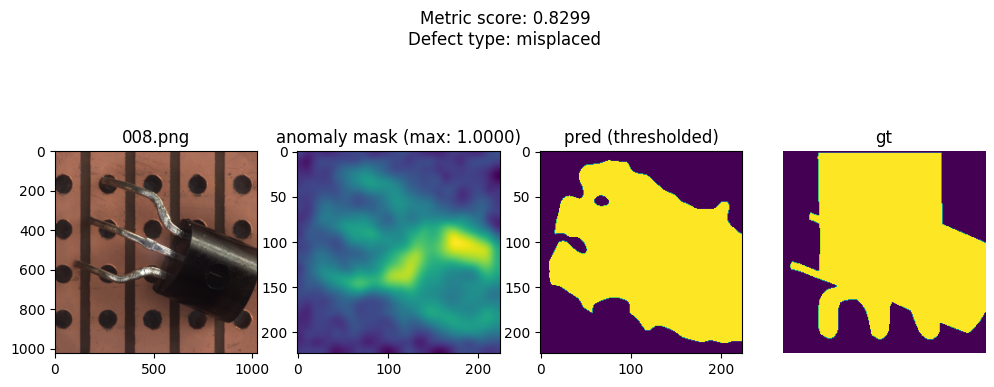

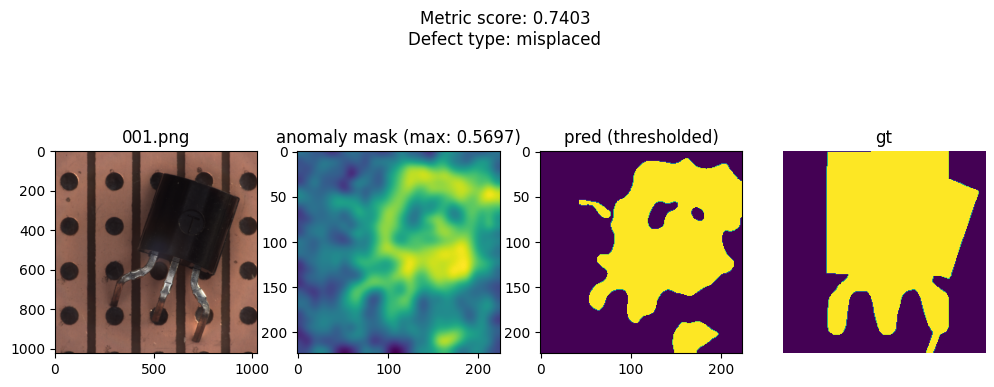

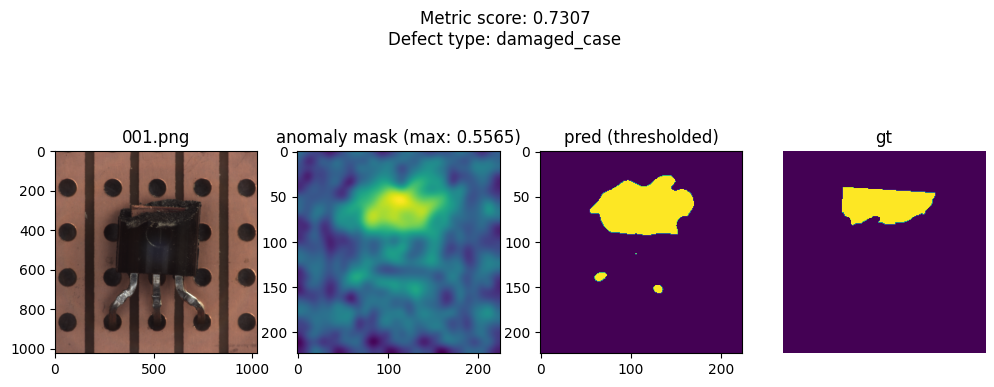

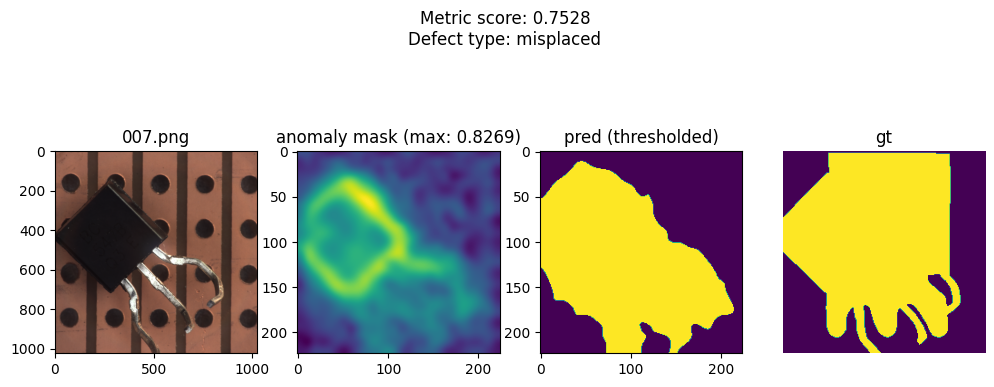

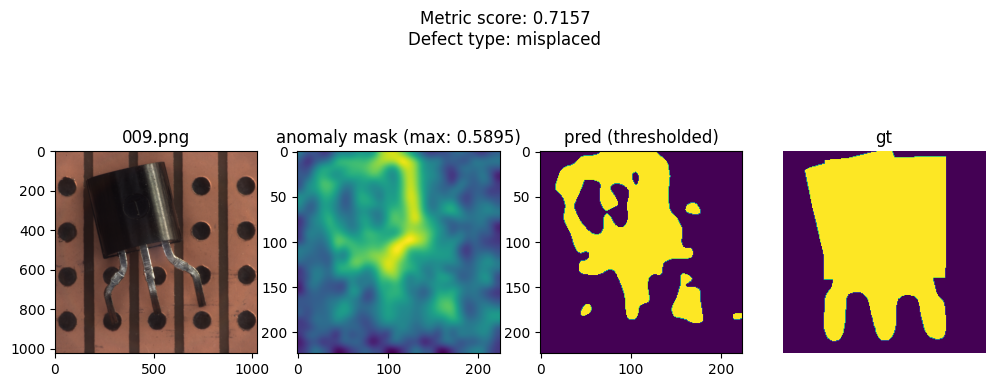

In [38]:
fnames, preds, gts, threshold, scores = get_examples_from_category(
    fpath2data=results_dst_folder, 
    num_examples=5, 
    best_category=False, 
    best_examples=True
)
plot_examples(fnames, preds, gts, scores, threshold)

Worst category - worst examples

           Row Names  instance_auroc  full_pixel_auroc  anomaly_pixel_auroc
0       mvtec_bottle        1.000000          0.981734             0.976010
1        mvtec_cable        0.971889          0.953732             0.945150
2      mvtec_capsule        0.963303          0.972025             0.969934
3       mvtec_carpet        0.985955          0.989872             0.987238
4         mvtec_grid        0.979114          0.964977             0.961541
5     mvtec_hazelnut        0.999643          0.982444             0.973581
6      mvtec_leather        1.000000          0.992893             0.990400
7    mvtec_metal_nut        0.967253          0.956465             0.952074
8         mvtec_pill        0.936716          0.948044             0.946133
9        mvtec_screw        0.747489          0.941260             0.939366
10        mvtec_tile        0.989899          0.955791             0.938607
11  mvtec_toothbrush        0.894444          0.970330             0.964594
12  mvtec_tr

Computing scores...: 40it [00:00, 60.79it/s]


Threshold: 0.3603


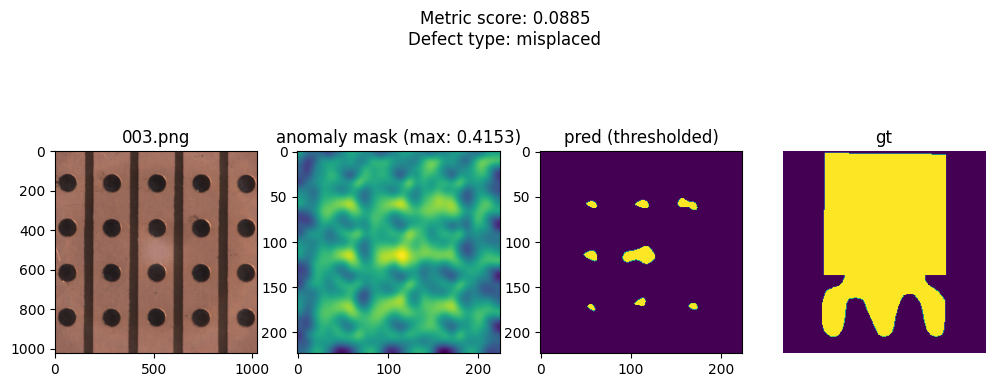

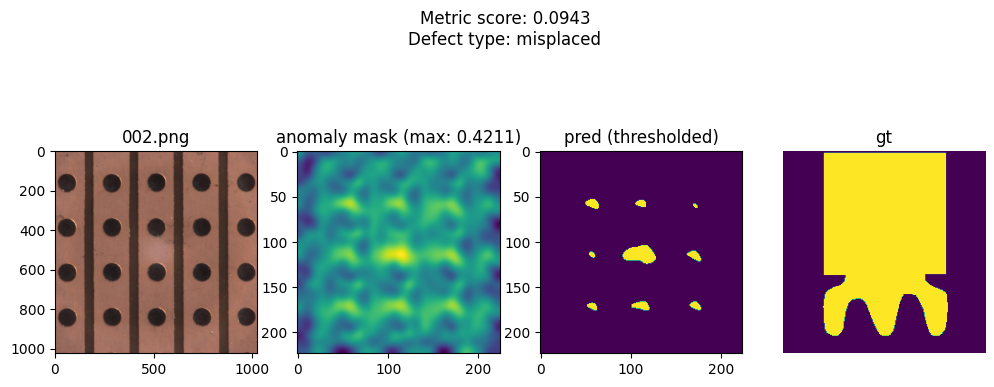

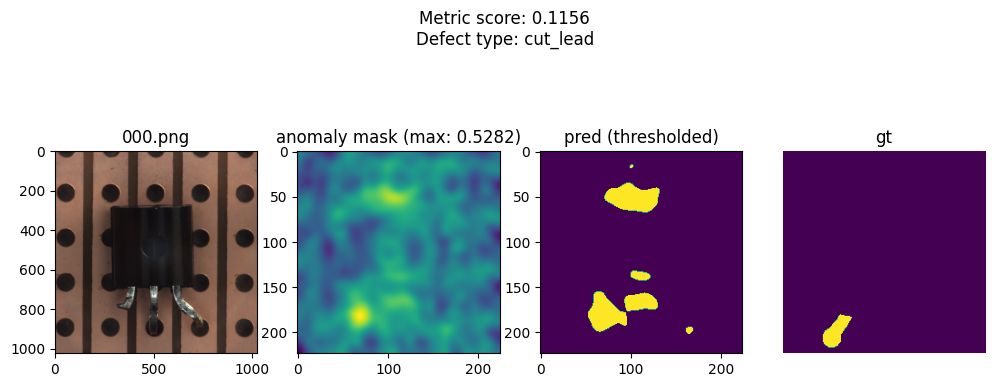

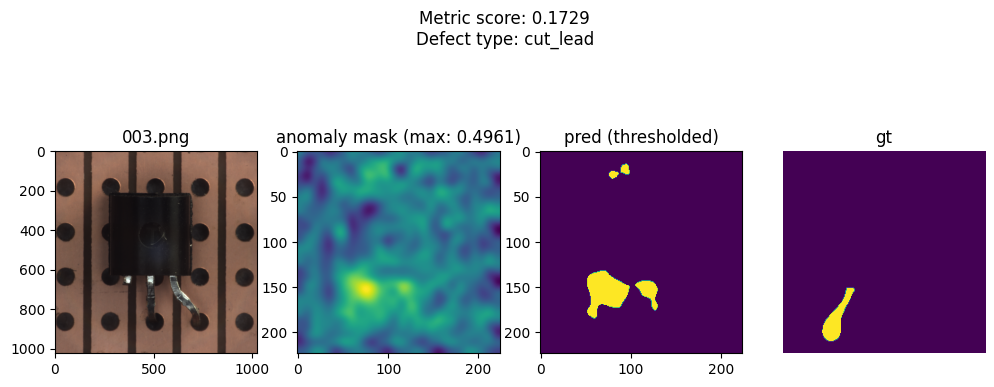

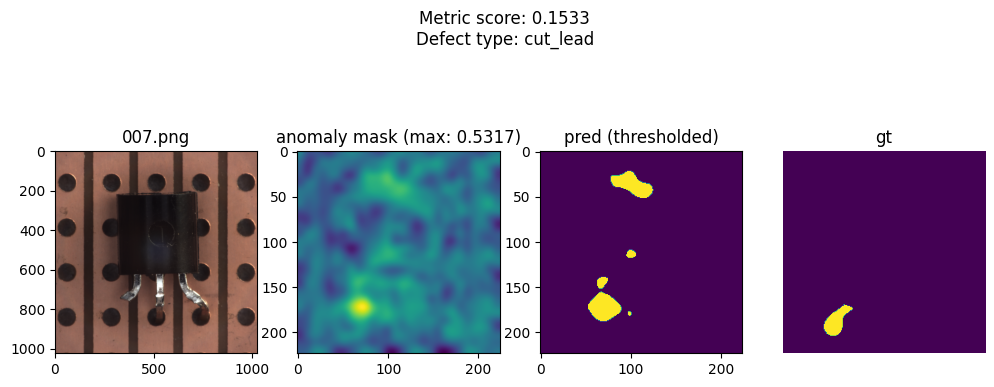

In [39]:
fnames, preds, gts, threshold, scores = get_examples_from_category(
    fpath2data=results_dst_folder, 
    num_examples=5, 
    best_category=False, 
    best_examples=False
)
plot_examples(fnames, preds, gts, scores, threshold)

## Step 7

Train the anomaly detection models for different image sizes in a selected range:

- Select some categories;
- Generate a plot showing the metric variation with respect to the image size change.

In [40]:
categories = ALL_CATEGORIES
exp_name = "0000"
resize_images = [50, 75, 100, 150, 224, 300]

In [ ]:
from bin.run_patchcore import main as trainer

from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

for resize_size in resize_images:
    with commandline_args(*get_train_args(
        exp_name=f"{exp_name}_{resize_size}", 
        dst_folders=(EXPERIMENTS_FOLDER, "step7"), 
        image_size=resize_size, 
        resize=resize_size, 
        categories=categories
    )):
        try:
            trainer()
        except SystemExit:
            print("-")

In [43]:
exp_folder = ROOT / EXPERIMENTS_FOLDER / "step7"

def plot_performance_vs_image_size(exp_folder: Path, selected_metric: str = "instance_auroc"):
    def merge_results() -> pd.DataFrame:
        dfs = []
        for exp in exp_folder.glob("*"):
            if not exp.is_dir():
                continue
            df = pd.read_csv(exp / "results.csv")[:-1]
            df["image_size"] = [int(exp.name.split("_")[-1])] * len(df)
            dfs.append(df)
        
        return pd.concat(dfs)

    def plot_df(df: pd.DataFrame) -> None:
        ax = None
        df = df.sort_values(by="image_size")
        categories = df["Row Names"].unique()
        
        for value in categories:
            _df = df[df["Row Names"] == value]
            ax = _df.plot(x="image_size", y=selected_metric, ax=ax, figsize=(20,10))
        
        ax.legend(categories)
        ax.set_title(f"Image size vs {selected_metric}")
        plt.show()

    df = merge_results()
    plot_df(df)

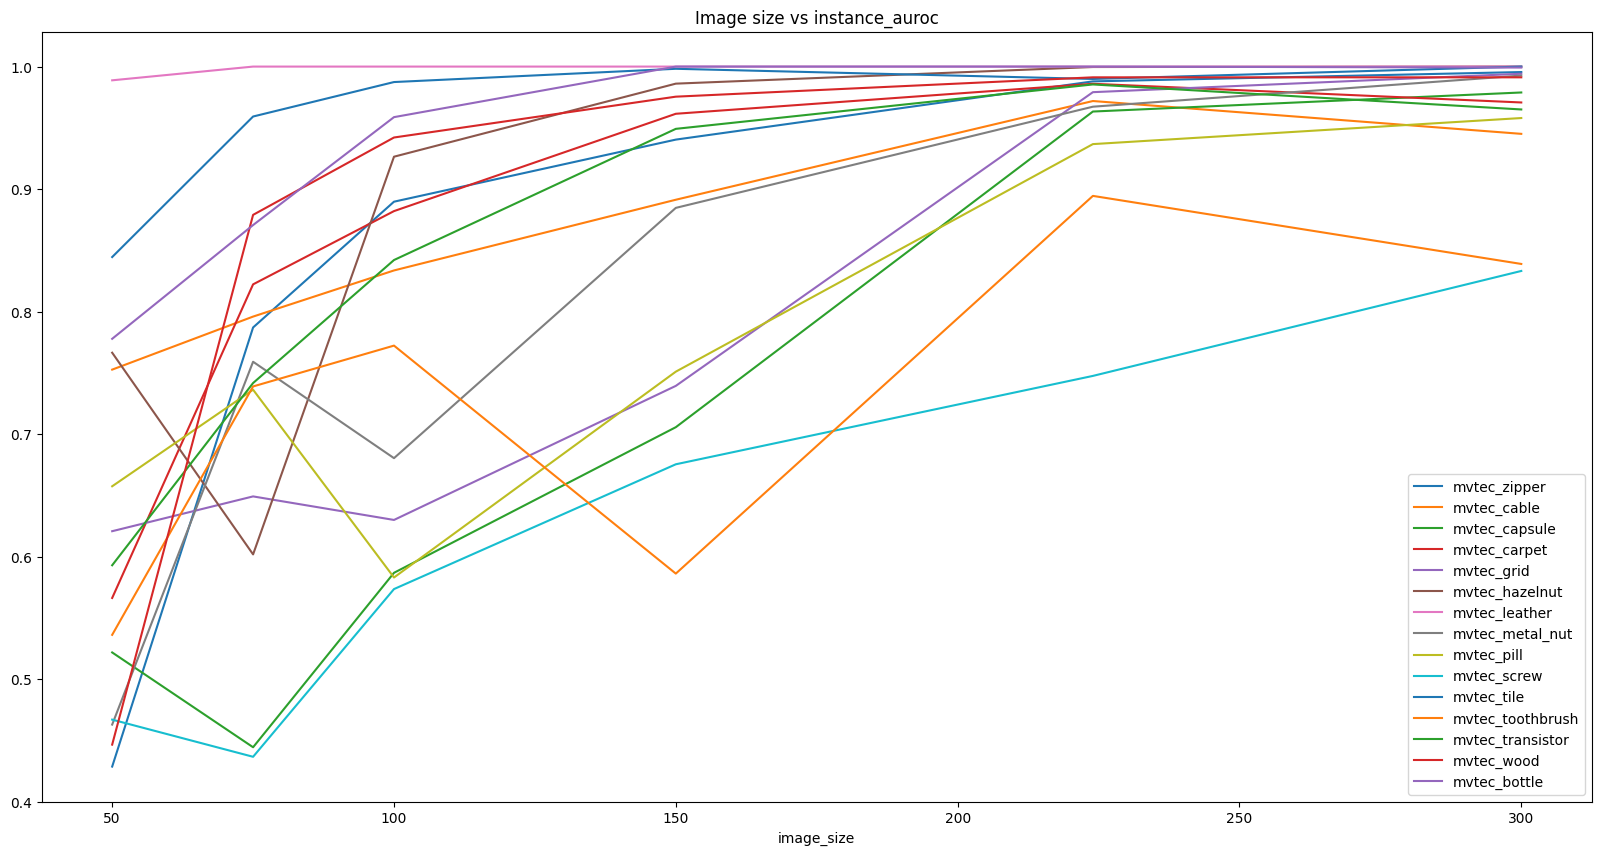

In [44]:
plot_performance_vs_image_size(exp_folder)